# Media Framing in News on Israel-Palestine War 2023

This notebook contains EDA, comparative analysis, and ML models for our NLP project on the news from two different media sources : Al-jazeera and BBC News.

The code for the news scraping could be found in py scripts..


## Import necessary packages

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import json
import pandas as pd
import random
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import NMF

import nltk
from nltk.corpus import stopwords

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

## Importing the Dataset:
## 1. ALJAZEERA

The following dataset includes the results of the first stage of scraping: the information on date, title, and link.

For information on how these data are retrieved check out Web Scraping repository, in particular aljazeera_selenium.py and aljazeera_links_scrape.py

In [2]:
alj_links = pd.read_json('src/aljazeera_links.json')
alj_links.head()

,date,title,link
0,2024-01-04,Dozens of Pales­tini­ans blind­fold­ed and de­...,https://www.aljazeera.com/program/newsfeed/202...
1,2024-01-04,US to send top diplo­mats to Mid­dle East as r...,https://www.aljazeera.com/news/2024/1/4/us-to-...
2,2024-01-04,"Is­rael’s war on Gaza: List of key events, day 90",https://www.aljazeera.com/news/2024/1/4/israel...
3,2024-01-04,Is­raeli mil­i­tary strikes south Lebanon stok...,https://www.aljazeera.com/news/2024/1/4/israel...
4,2024-01-04,Is­raeli mil­i­tary strikes south Lebanon stok...,https://www.aljazeera.com/news/2024/1/4/israel...


In [3]:
alj_links['title'][0]

'Dozens of Pales\xadtini\xadans blind\xadfold\xaded and de\xadtained in oc\xadcu\xadpied West Bank raid'

In [4]:
alj_links['title'] = alj_links['title'].str.replace('\xad', '')

In [5]:
alj_links['date'] = pd.to_datetime(alj_links['date'])
print("The earliest date scraped is",alj_links['date'].min().strftime('%Y-%m-%d'),
      "and the latest date scraped is", alj_links['date'].max().strftime('%Y-%m-%d'))

The earliest date scraped is 2023-11-13 and the latest date scraped is 2024-01-04


In [6]:
alj_links = alj_links[(alj_links['date'] < pd.Timestamp('2024-01-01')) &
                      (alj_links['date'] > pd.Timestamp('2023-10-06'))]
alj_links['date'] = alj_links['date'].dt.strftime('%Y-%m-%d')
print("There are", len(alj_links), "news published between 7 October 2023 and 31 October 2023 in Aljazeera dataset.")

There are 960 news published between 7 October 2023 and 31 October 2023 in Aljazeera dataset.


This second dataset is composed of the results of the second stage of scraping, which scraped the all pages in the url list. It contains information on news title, news subhead, body and link.

To have more information on the scraping code, see aljazeera_news.py

In [7]:
pd.set_option('display.max_rows', None)
alj = pd.read_json('src/alj_news.json')
alj.head(5)

,title,body,subhead,link
0,Peace and potato chips: Gaza dreams big and sm...,[],None,https://www.aljazeera.com/features/longform/20...
1,"US army attacks three Houthi boats in Red Sea,...",[Yemen’s Houthi rebels say they have lost at l...,Global shipping giant Maersk suspends operatio...,https://www.aljazeera.com/news/2023/12/31/us-f...
2,"Israel-Hamas war: List of key events, day 86","[Here’s how things stand on Sunday, December 3...","At least 100 killed in central Gaza, while nig...",https://www.aljazeera.com/news/2023/12/31/isra...
3,‘Outraged’: Brazilian Muslims face growing Isl...,[ It wasn’t unusual for patients to arrive in ...,A survey released last month suggests approxim...,https://www.aljazeera.com/news/2023/12/31/outr...
4,Pro-Palestine campaigners call for Gaza ceasef...,[Activists have launched a global campaign ask...,Activists are asking people to turn the New Ye...,https://www.aljazeera.com/news/2023/12/31/pro-...


We would like to have a dataset that have content and date informations together, we achieved this by merging the two datasets above on the link column.
Also, we will add the text in the subhead also into the body column.

In [8]:
alj = pd.merge(alj, alj_links.drop('title', axis=1), on='link', how='inner')
alj['subhead'] = alj['subhead'].apply(lambda x: "" if x == None else x)
alj['subhead'] = alj['subhead'].apply(lambda x: x.split(". ")[:-1])
alj['body'] = alj['subhead'] + alj['body']
alj.head()

,title,body,subhead,link,date
0,Peace and potato chips: Gaza dreams big and sm...,[],[],https://www.aljazeera.com/features/longform/20...,2023-12-31
1,"US army attacks three Houthi boats in Red Sea,...",[Yemen’s Houthi rebels say they have lost at l...,[],https://www.aljazeera.com/news/2023/12/31/us-f...,2023-12-31
2,"Israel-Hamas war: List of key events, day 86","[Here’s how things stand on Sunday, December 3...",[],https://www.aljazeera.com/news/2023/12/31/isra...,2023-12-31
3,‘Outraged’: Brazilian Muslims face growing Isl...,[ It wasn’t unusual for patients to arrive in ...,[],https://www.aljazeera.com/news/2023/12/31/outr...,2023-12-31
4,Pro-Palestine campaigners call for Gaza ceasef...,[Activists have launched a global campaign ask...,[],https://www.aljazeera.com/news/2023/12/31/pro-...,2023-12-31


### Cleaning the Data

We will need to clean the dataset to make it suitable for english language NLP packages. Let's start by printing out all unique characters used in the text.

In [9]:
corpus = " ".join(alj['body'].apply(lambda x: ' '.join(x)))
unique_char = set(re.findall(r'.', corpus)) #gives all characters, r'\w' gives alphanumerical
print(unique_char)

{'e', '”', 'a', 'ץ', 'ח', 'ד', 'j', '💙', 'n', 'د', 'ศ', '7', '⤵', '⛽', '#', '👉', 'ล', 'ป', 'V', '🏽', '𝐆', '่', 'ó', '𝐥', '\u200b', 'h', 'R', '4', "'", 'ذ', '𝐨', '🇸', '𝐠', 'E', '📢', '𝐩', 'v', '😔', 'غ', 'ณ', 'è', '\r', 'ש', 'Q', 'ف', 'ّ', 'น', 'َ', 'נ', 'ช', 'ي', '💔', '𝐒', 'ã', 'O', '%', '>', '𝐚', '[', 'q', 'ด', 'ה', 'و', 'ע', 'p', 'ج', 'ُ', 'ן', '𝐮', '״', 'م', ':', 'u', 'ื', 'í', 'خ', 'N', 'X', 'l', '𝐛', 'า', 'ิ', 'T', 'ט', '𝐤', 'ط', '=', 'ำ', '6', '\u200c', '🚑', '🇱', 'ๆ', '🔴', 'A', 'ג', 'ง', 't', 'ب', 'F', '𝐞', '-', '8', 'ר', 'ו', 'ת', 'א', '\U0001faac', 'צ', 'M', 'ت', 'ל', '𝐰', 'ק', 'õ', 'L', '้', ' ', 'แ', '🇨', 'ז', 'ู', 'ต', '𝐟', '9', 'ะ', '3', '👇', '💕', 'จ', 'Т', '0', 'ñ', 'פ', 'H', 'ع', 'ك', 'K', 'C', '“', 'ه', 'ร', 'ฝ', '—', '➡', 'ุ', '𝐝', ')', '\u200f', 'י', '🇦', '\t', '_', 'ü', 'r', '🇮', 'U', '⚠', 'เ', 'ส', '‘', '𝐜', '$', '1', 'x', '+', 'á', '/', 'ï', '📸', 'ء', 'o', 'i', '?', ';', 's', 'ท', 'ไ', '𝐧', '🇰', 'ี', 'ך', '𝐳', 'ê', 'ْ', '🇵', 'S', 'c', 'z', '’', 'מ', 'อ', '.', 'ض', '𝐭'

The below function reparses the sentences after cleaning the texts.
The reason we wanted to fusion and reparse it again is because we noticed the sentences we not parsed properly.

In [10]:
def reparse_sentences(text):
    texts = " ".join(text)
    #clean_text = re.sub(r'[^\w\s.,!?\'-]', '', texts)
    clean_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', texts) # 
    clean_text = re.sub(r'\t', '', clean_text)
    clean_text = re.sub(r'\xa0', ' ', clean_text)
    clean_text = re.sub(r'\s\s+', ' ', clean_text)
    # Properly split sentences by period while keeping the period attached to the first string
    clean_text = re.split(r'(?<=[.!?])\s', clean_text)
  
    
    return clean_text
#let's test the function

reparse_sentences(alj['body'][11])

['Almost 23,000 people – the vast majority Palestinian – have been killed since the unprecedented Hamas attacks in southern Israel on October 7, which launched the Israeli assault on Gaza.',
 'As the end of 2023 approaches, the Israeli offensive is showing no signs of any let-up and the death toll is certain to rise on both sides as fighting continues.',
 'Political attempts at peace have failed.',
 'Israel has stated from the outset that its objective is to eliminate Hamas’s military and governing capabilities.',
 'To this end, it has continued the aerial bombardment and ground invasion of the Gaza Strip almost without pause, since October 7.',
 'While Israel admits it has failed in this mission so far, it claims it is just question of time before it achieves this goal.',
 'But does the situation on the ground support that claim?',
 'The answer is cautious no.',
 'detailed and impartial analysis of various aspects of its performance leads to the conclusion that so far, Hamas has exper

Now we are ready to apply it to the entire body column.

In [11]:
alj['body'] = alj['body'].apply(lambda x: reparse_sentences(x))

In [12]:
alj['source'] = 'Aljazeera'
alj = alj[['title', 'body', 'date', 'source', 'link']]

In [13]:
alj.head()

,title,body,date,source,link
0,Peace and potato chips: Gaza dreams big and sm...,[],2023-12-31,Aljazeera,https://www.aljazeera.com/features/longform/20...
1,"US army attacks three Houthi boats in Red Sea,...",[Yemen’s Houthi rebels say they have lost at l...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/us-f...
2,"Israel-Hamas war: List of key events, day 86","[Here’s how things stand on Sunday, December 3...",2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/isra...
3,‘Outraged’: Brazilian Muslims face growing Isl...,[ It wasn’t unusual for patients to arrive in ...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/outr...
4,Pro-Palestine campaigners call for Gaza ceasef...,[Activists have launched global campaign askin...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/pro-...


## 2. BBC News

The following dataset includes the results of the first stage of scraping: the information on date, title, and link.

For information on how these data are retrieved check out Web Scraping repository, in particular bbc_scrape_links.py

In [14]:
pd.set_option('display.max_rows', None)
bbc_links = pd.read_json('src/bbc_links.json')
bbc_links.head()

,url,date
0,https://www.bbc.com/news/business-67759593,2024-01-09 10:14:00
1,None,NaT
2,https://www.bbc.com/news/world-middle-east-678...,2024-01-01 21:47:00
3,https://www.bbc.com/news/world-middle-east-678...,2023-12-31 17:54:00
4,https://www.bbc.com/news/world-middle-east-678...,2023-12-30 21:24:00


In [15]:
bbc_links['date'] = pd.to_datetime(bbc_links['date'])
print("The earliest date scraped is",bbc_links['date'].min().strftime('%Y-%m-%d'),
      "and the latest date scraped is", bbc_links['date'].max().strftime('%Y-%m-%d'))

The earliest date scraped is 2023-10-12 and the latest date scraped is 2024-01-09


#### Attention:
Unfortunately BBC website did not allow us to access links earlier than 12 October. 
Since we find news from this period important we have used google search to cover the links of news from 7 to 11 October. 
Below, you can see a list of urls to append to the previously scraped ones while scraping article contents.

For more details on the scraping process of these urls, check out bbc_scrape_news.py

In [16]:
google_bbc = ['https://www.bbc.com/news/world-europe-67356581',
              'https://www.bbc.com/news/live/world-middle-east-67364296',
              'https://www.bbc.com/news/world-africa-67257862',
              'https://www.bbc.com/news/live/world-middle-east-67364296',
              'https://www.bbc.com/news/world-middle-east-67390375',
              'https://www.bbc.com/news/live/world-middle-east-67339462',
              'https://www.bbc.com/news/world-middle-east-67355319',
              'https://www.bbc.com/news/world-middle-east-67327079',
              'https://www.bbc.com/news/world-middle-east-67372035',
              'https://www.bbc.com/news/world-middle-east-67372661',
              'https://www.bbc.com/news/world-europe-67356581',
              'https://www.bbc.com/news/world-us-canada-67354706',
              'https://www.bbc.com/news/world-67273969',
              'https://www.bbc.com/news/world-us-canada-67342868',
              'https://www.bbc.com/news/world-middle-east-67373293',
              'https://www.bbc.co.uk/news/uk-england-kent-67378052',
              'https://www.bbc.com/news/world-middle-east-67385617',
              'https://www.bbc.com/news/world-middle-east-67375667',
              'https://www.bbc.com/news/world-asia-67353188',
              'https://www.bbc.com/news/world-middle-east-67345430',
              'https://www.bbc.com/news/world-middle-east-67321241',
              'https://www.bbc.com/news/world-us-canada-67339982',
              'https://www.bbc.com/news/world-middle-east-67376148',
              'https://www.bbc.com/news/world-middle-east-67373461',
              'https://www.bbc.com/sport/africa/67228507',
              'https://www.bbc.com/news/world-europe-67368409',
              'https://www.bbc.com/news/uk-scotland-scotland-politics-67367577',
              'https://www.bbc.com/news/world-middle-east-67350709',
              'https://www.bbc.com/news/world-67349605',
              'https://www.bbc.com/news/uk-scotland-edinburgh-east-fife-67344032',
              'https://www.bbc.com/news/live/uk-67390343',
              'https://www.bbc.com/pidgin/articles/cv2zwjlp701o',
              'https://www.bbc.com/news/uk-67349474',
              'https://www.bbc.com/news/world-67374801',
              'https://www.bbc.com/news/uk-67367617',
              'https://www.bbc.com/news/uk-67366031',
              'https://www.bbc.com/news/world-us-canada-67336799',
              'https://www.bbc.com/news/uk-wales-politics-67357824',
              'https://www.bbc.com/news/uk-wales-politics-67343909',
              'https://www.bbc.com/pidgin/articles/c4n4z40eve2o',
              'https://www.bbc.com/news/uk-england-merseyside-67367560',
              'https://www.bbc.com/news/world-us-canada-67342387',
              'https://www.bbc.com/news/av/world-europe-67399096',
              'https://www.bbc.com/news/uk-england-leeds-67363678',
              'https://www.bbc.com/news/uk-politics-67364797',
              'https://www.bbc.com/news/world-middle-east-67391335',
              'https://www.bbc.com/news/uk-politics-67353019',
              'https://www.bbc.com/news/uk-england-manchester-67370101',
                           
             ]

In [17]:
bbc = pd.read_json('src/bbc_news.json')
bbc.head()

,title,bold,body,date,link
0,Israel-Gaza war: Displaced Gazans 'living in t...,"Many displaced Gazans are living ""in the open,...",[According to the UN's humanitarian office (OC...,2023-12-30 21:24:54+00:00,https://www.bbc.com/news/world-middle-east-678...
1,Why 2023 was an uncomfortable year for the West,The past 12 months have seen a number of setba...,"[On many fronts, the wind is blowing in the wr...",2023-12-30 01:06:21+00:00,https://www.bbc.com/news/world-67845056
2,What do Red Sea assaults mean for global trade?,Global supply chains could face severe disrupt...,[Attacks by Houthi rebels in Yemen on commerci...,2024-01-04 10:14:29+00:00,https://www.bbc.com/news/business-67759593
3,South Africa files ICJ case accusing Israel of...,South Africa has filed a case at the Internati...,[The UN court confirmed the application concer...,2023-12-29 21:19:08+00:00,https://www.bbc.com/news/world-africa-67844551
4,Israel says war in Gaza expected to continue t...,The Israeli military has said it expects the c...,"[In a new year's message, the Israel Defense F...",2024-01-01 21:47:21+00:00,https://www.bbc.com/news/world-middle-east-678...


In [18]:
bbc['date'] = pd.to_datetime(bbc['date'])
print("The earliest date scraped is",bbc_links['date'].min().strftime('%Y-%m-%d'),
      "and the latest date scraped is", bbc_links['date'].max().strftime('%Y-%m-%d'))

The earliest date scraped is 2023-10-12 and the latest date scraped is 2024-01-09


In [19]:
bbc['body'] = bbc['body'].apply(lambda x: tuple(x) if x is not None else None)

# Drop duplicates after converting lists to tuples across multiple columns
bbc = bbc.drop_duplicates().reset_index(drop=True)
# Revert tuples back to lists
bbc['body'] = bbc['body'].apply(lambda x: list(x) if x is not None else x)

bbc['date'] = bbc['date'].dt.strftime('%Y-%m-%d')
print("There are", len(bbc), "news published between 7 October 2023 and 31 October 2023 in BBC dataset.")

There are 685 news published between 7 October 2023 and 31 October 2023 in BBC dataset.


Let's replicate the same steps we applied for Aljazeera news dataset:
- merge the subhead / bold column into the body
- clean and reparse sentences

In [20]:
bbc['bold'] = bbc['bold'].apply(lambda x: "" if x == None else x)
bbc['bold'] = bbc['bold'].apply(lambda x: x.split(". ")[:-1])
bbc['body'] = bbc['bold'] + bbc['body']
bbc.head()

,title,bold,body,date,link
0,Israel-Gaza war: Displaced Gazans 'living in t...,[],[According to the UN's humanitarian office (OC...,2023-12-30,https://www.bbc.com/news/world-middle-east-678...
1,Why 2023 was an uncomfortable year for the West,[The past 12 months have seen a number of setb...,[The past 12 months have seen a number of setb...,2023-12-30,https://www.bbc.com/news/world-67845056
2,What do Red Sea assaults mean for global trade?,[],[Attacks by Houthi rebels in Yemen on commerci...,2024-01-04,https://www.bbc.com/news/business-67759593
3,South Africa files ICJ case accusing Israel of...,[],[The UN court confirmed the application concer...,2023-12-29,https://www.bbc.com/news/world-africa-67844551
4,Israel says war in Gaza expected to continue t...,[The Israeli military has said it expects the ...,[The Israeli military has said it expects the ...,2024-01-01,https://www.bbc.com/news/world-middle-east-678...


In [21]:
bbc['body'] = bbc['body'].apply(lambda x : reparse_sentences(x))

In [22]:
bbc['source'] = 'BBC'
bbc = bbc[['title', 'body', 'date', 'source', 'link']]

## Concatenate two dataset

In [23]:
df = pd.concat([alj, bbc], ignore_index=True)
df.head()

,title,body,date,source,link
0,Peace and potato chips: Gaza dreams big and sm...,[],2023-12-31,Aljazeera,https://www.aljazeera.com/features/longform/20...
1,"US army attacks three Houthi boats in Red Sea,...",[Yemen’s Houthi rebels say they have lost at l...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/us-f...
2,"Israel-Hamas war: List of key events, day 86","[Here’s how things stand on Sunday, December 3...",2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/isra...
3,‘Outraged’: Brazilian Muslims face growing Isl...,[ It wasn’t unusual for patients to arrive in ...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/outr...
4,Pro-Palestine campaigners call for Gaza ceasef...,[Activists have launched global campaign askin...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/pro-...


Let's save the final version of our dataset.

In [24]:
df.to_json("all_news.json")

# Exploratory Data Analysis

### Distribution of News across Sources

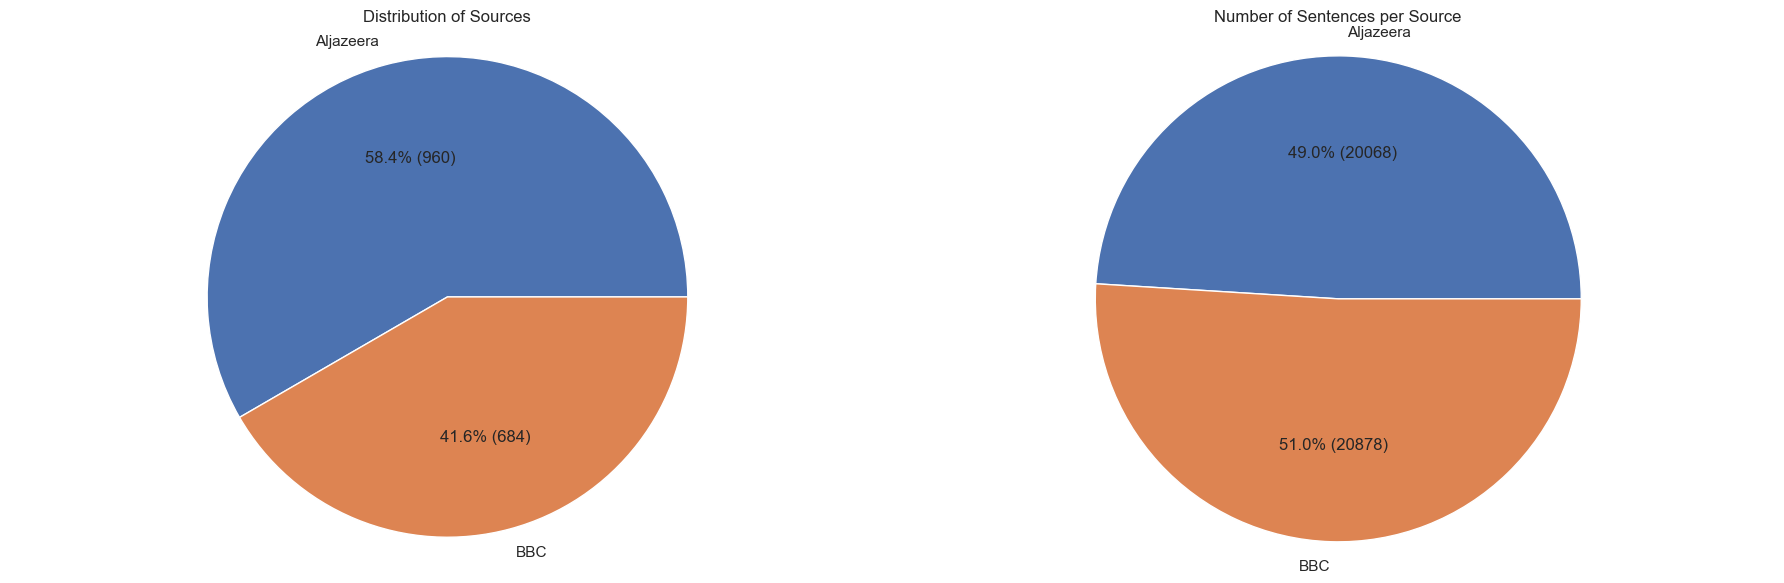

In [42]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

source_counts = df['source'].value_counts()

#axs[0].pie(source_counts, labels=source_counts.index, autopct='%1.1f%%')
axs[0].pie(source_counts, labels=source_counts.index, 
           autopct=lambda pct: f"{pct:.1f}% ({int(pct * sum(source_counts) / 100)})")
axs[0].set_title('Distribution of Sources')
axs[0].axis('equal')


data = df[['body', 'source']]
data['num_sentences'] = df['body'].apply(len)

source_sentence_counts = data.groupby('source')['num_sentences'].sum()

axs[1].pie(source_sentence_counts, labels=source_sentence_counts.index,
           #autopct='%1.1f%%',
          autopct=lambda pct: f"{pct:.1f}% ({int(pct * sum(source_sentence_counts) / 100)})")
axs[1].set_title('Number of Sentences per Source')


axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle



plt.tight_layout()
plt.show()

- Above we see that the dataset is slightly imbalanced with a larger subsample coming from Aljazeera News compared to BBC News.
- On the other hand, we see this imbalance being compensated when we check the number of sentences in our dataset, which also implies that BBC articles in our dataset tend to contain more sentences than Aljazeera.

In [43]:
sentence_counter = 0
for text in df['body']:
    sentence_counter += len(text)

print("Total number of sentences is", sentence_counter)

sentence_bbc = 0
for text in (df[df['source'] == 'BBC']['body']):
    sentence_bbc += len(text)
        

sentence_alj = 0
for text in (df[df['source'] == 'Aljazeera']['body']):
    sentence_alj += len(text)
        
print("There are", sentence_bbc, "sentences retrieved from BBC and", 
      sentence_alj, "sentences retrieved from Ajazeera.")

Total number of sentences is 40947
There are 20878 sentences retrieved from BBC and 20069 sentences retrieved from Ajazeera.


In [31]:
df['text'] =  df['body'].apply(lambda x: " ".join(x))
df.head()

,title,body,date,source,link,text
0,Peace and potato chips: Gaza dreams big and sm...,[],2023-12-31,Aljazeera,https://www.aljazeera.com/features/longform/20...,
1,"US army attacks three Houthi boats in Red Sea,...",[Yemen’s Houthi rebels say they have lost at l...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/us-f...,Yemen’s Houthi rebels say they have lost at le...
2,"Israel-Hamas war: List of key events, day 86","[Here’s how things stand on Sunday, December 3...",2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/isra...,"Here’s how things stand on Sunday, December 31..."
3,‘Outraged’: Brazilian Muslims face growing Isl...,[ It wasn’t unusual for patients to arrive in ...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/outr...,It wasn’t unusual for patients to arrive in f...
4,Pro-Palestine campaigners call for Gaza ceasef...,[Activists have launched global campaign askin...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/pro-...,Activists have launched global campaign asking...


In [27]:
df['date'] = pd.to_datetime(df['date'])

In [28]:
print("The total number of news in the merged dataset is", len(df))

The total number of news in the merged dataset is 1645


### Frequent words from News Headlines

A simple and efficient way of EDA with textual data is to generate wordclouds.  The primary purpose of a word cloud is to visually represent the frequency or importance of words in a textual dataset, where the size of each word reflects its frequency in the provided text.

Below we present a generic, and two source-specific word clouds for exploratory purposes.

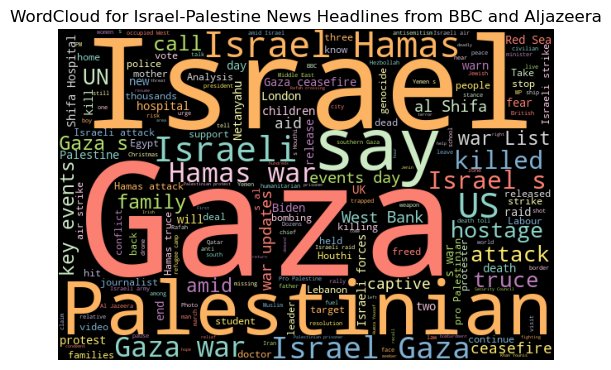

In [29]:
words = ''
for document in df['title']:
    words += document + ' '
wordcloud = WordCloud(width=600, height=400, background_color='#000000', colormap='Set3').generate(words)
plt.imshow(wordcloud)
plt.title("WordCloud for Israel-Palestine News Headlines from BBC and Aljazeera")
plt.axis('off')
plt.show()

- The wordcloud map above visualizes the most frequent word from news headlines in our dataset. As one might, two most frequent words are "Gaza" and "Israel", followed by words like "Palestinian", "Hamas", "war" and "say".
- We can expect to find similar results also for the news contents. 
- However, let's generate a wordcloud for news contents too, but this time visualizing a different map for each of the sources.

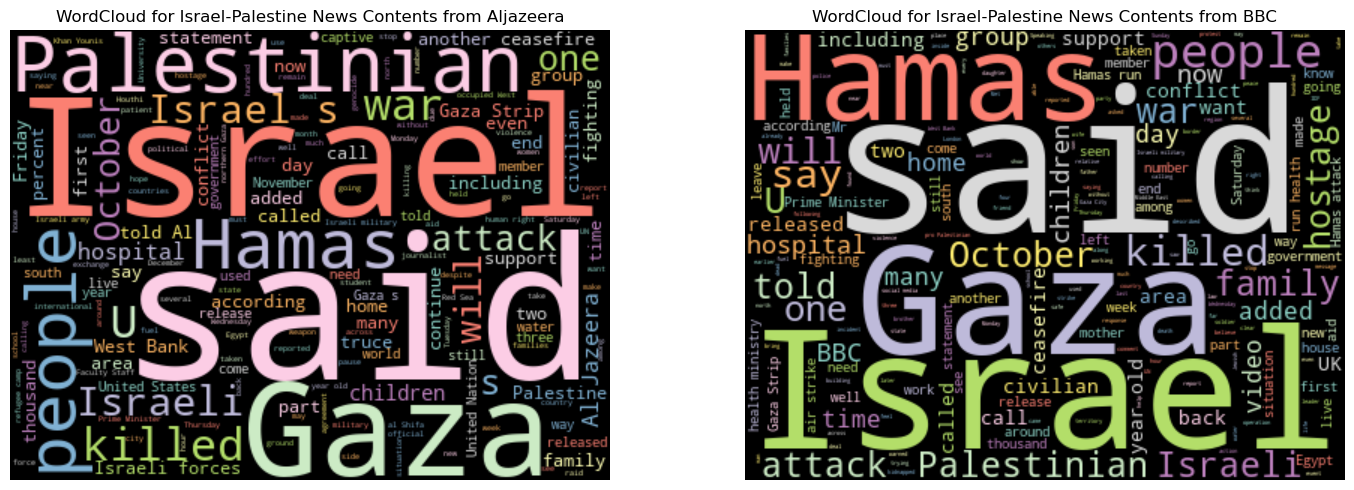

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate through each unique source and create a word cloud
for i, source in enumerate(set(df['source'])):
    words = ''
    for document in df[df['source'] == source]['text']:
        words += document + ' '
    wordcloud = WordCloud(width=400, height=300, background_color='#000000', colormap='Set3').generate(words)
    
    # Plot the word cloud in a separate subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title("WordCloud for Israel-Palestine News Contents from {}".format(source))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Differently from the headlines, the word "said" seems to acquire a higher relative frequency in the news contents, which is actually quite intuitive.
Though two sources seem to have similar results at a first glance, there are a few important differences that might matter and that might deserve further attention:
- While the word "Palestinian" appears as one of the most frequent words in Aljazeera articles, it has a significantly lower occurrence in the BBC contents compared to the words "Israel", "Gaza" and "said".
- A second major difference is that the word "Hamas" appears among the top frequent words in BBC news articles while having a lower relative frequency in the Al-jazeera's contents.
- This might be a hint for two different portrayals of the ongoing war: 
    - one between Israel and Gaza, affecting Palestinians as well as Israelis with Hamas being only a partial actor in the Aljazeera coverage
    - another one, rather between Israel and Hamas, taking place again in Gaza, Palestinians who are affected are only a very small portion of the story in the BBC coverage.
    
However, before arriving to any conclusion, we should dig deeper than the most frequent word analyses.

### Keyword Counts
One important indicator of framing and bias in the media is word choices, especially in the coverages of deathly events. Below we created a keyword list of words referring to war and death, frequently appeared in the recent news.

- Note that some of them have a rather neutral connotation in describing war-like events such as "dead, kill, ceasefire",
- whereas others are considered more ideologically-weighted such as "genocide, islamophobia, Zionism, behead", etc.

In [47]:
keywords = [
    "annihilat",
    "attack",
    "hostage",
    "captive",
    "ceasefire|truce",
    "condemn",
    "die",
    "displace",
    "dead",
    "hamas",
    "hostage",
    "israeli",
    "kill",
    "murder",
    "massacre",
    "antisemitism|antisemitic",
    "antimuslim",
    "apartheid",
    "barbaric",
    "behead",
    "bloodshed",
    "decapitate",
    "ethnic cleansing",
    "genocide",
    "colonialism",
    "human animals",
    "islamophobia|islamophobic",
    "invade|invader",
    "Jihad",
    "occupation|occupied",
    "palestinian",
    "savage",
    "slaughter",
    "terror|terrorism|terrorist",
    "Zionism|Zionist"
     
    
]

In [48]:
def standardize(text):
    text =  re.sub(r'anti-semitism', 'antisemitism', text, flags=re.IGNORECASE)
    text =  re.sub(r'anti-semitic', 'antisemitic', text, flags=re.IGNORECASE)
    text = re.sub(r'anti-muslim', 'antimuslim', text, flags=re.IGNORECASE)
    return text

df['text'] = df['text'].apply(lambda x : standardize(x))

#### Example Keyword Search:

In [49]:
count_killed = 0
for i in range(len(df)):
    occurrences = re.findall(r'killed', df['text'][i], flags=re.IGNORECASE)
    count_killed += len(occurrences)

print(f"The word 'killed' appears {count_killed} times in", sentence_counter, "sentences")

The word 'killed' appears 2493 times in 40947 sentences


In [50]:
def calculate_word_frequencies(texts, keywords):
    keyword_freq = {keyword: [] for keyword in keywords}

    for keyword in keywords:
        total_occurrences = 0
        search = re.compile(rf'{keyword}', re.IGNORECASE)

        for text in texts:
            occurrences = len(search.findall(text))
            total_occurrences += occurrences
        keyword_freq[keyword] = total_occurrences
    
    return keyword_freq




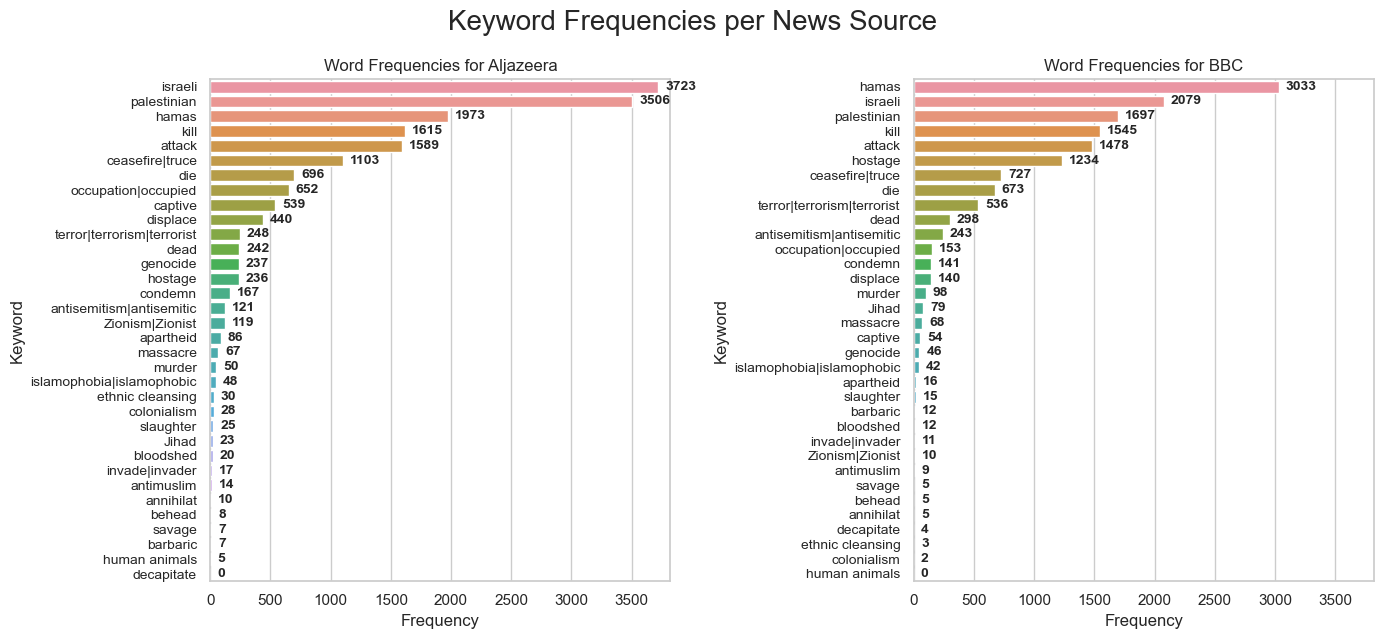

In [51]:
plt.figure(figsize=(14, 6.5))
max_frequency = 0

for i, source in enumerate(df['source'].unique()):
    texts_source = df[df['source'] == source]['text']
    freq_source = calculate_word_frequencies(texts_source, keywords)
    
    # Create a DataFrame for the current source's word frequencies
    df_source = pd.DataFrame(pd.Series(freq_source), columns=['frequency']).reset_index()
    df_source.columns = ['keyword', 'frequency'] 
    
    # Sort words by frequency in descending order
    df_source_sorted = df_source.sort_values(by='frequency', ascending=False)
    
    # Plotting the barplot for the current source with words in descending frequency
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(data=df_source_sorted, x='frequency', y='keyword')
    plt.title(f'Word Frequencies for {source}')
    plt.xlabel('Frequency')
    plt.ylabel('Keyword')
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    xytext=(5, 0), 
                    textcoords='offset points', 
                    ha='left', 
                    va='center', 
                    fontsize=10,
                    fontweight='bold')

    # Reduce y-axis label font size
    ax.tick_params(axis='y', labelsize=10)  # Adjust labelsize as needed
    
    max_frequency = max(max_frequency, df_source['frequency'].max())

# Set the same x-axis limits for both subplots
for i in range(1, 3):
    plt.subplot(1, 2, i)
    plt.xlim(0, max_frequency + 100) 

plt.suptitle('Keyword Frequencies per News Source', fontsize=20)
plt.tight_layout()
plt.show()

The top three bars of the figure above visualizes and reaffirms some of our findings from the wordclouds in a quantitative manner:
- Among the words "Palestinian","Israeli" and "Hamas", BBC news refers to the "Hamas" twice as more frequently as "Palestinians" whereas "Hamas" constitutes a smaller part of the Al-jazeera coverage.
The figure also offers some key insights on word selections:
- the terms more affiliated with a pro-palestinian stance such as "genocide" or "Zionism" appear relatively more frequently in Al-jazeera than in BBC
- whereas terms with a rather pro-Israel connotation such as "antisemitism" or "condemn" have a higher relative occurrence in BBC contents than in Al-jazeera
- Interestingly, the words with a more explicit bias and framing such as "savage", "barbaric", "human animals" have an equivalent (higher in the case of "human animals") appearance in two sources, yet Al-jazeera's choice comes from a decision to cite and call out the use of this vocabulary.
- A significant variation exists between the two sources also on the use of the word "hostage". While the hostages are referred to over 1200 times in BBC content, the word receives nearly 6 times less coverage in Al-Jazeera news. Interestingly, the latter source seems to display a preference towards the word "captive" rather than "hostage" even in the instances of referring to the same event.Cambridge Dictionary defines these two words as follows: 
    - captive: someone who is kept as a prisoner
    - hostage: someone who is taken as a prisoner by an enemy in order to force the other people involved to do what the enemy wants

Hence, these word choices seem like an instance of media framing.

This reminds us that without taking the context into account word choice does not fully reveals a medium's stance.

Also, remember that the dataset was not fully balanced between two sources, as we have accessed to more news from Al-jazeera than BBC. Let's adjust this by normalizing word occurrences by the number of articles.

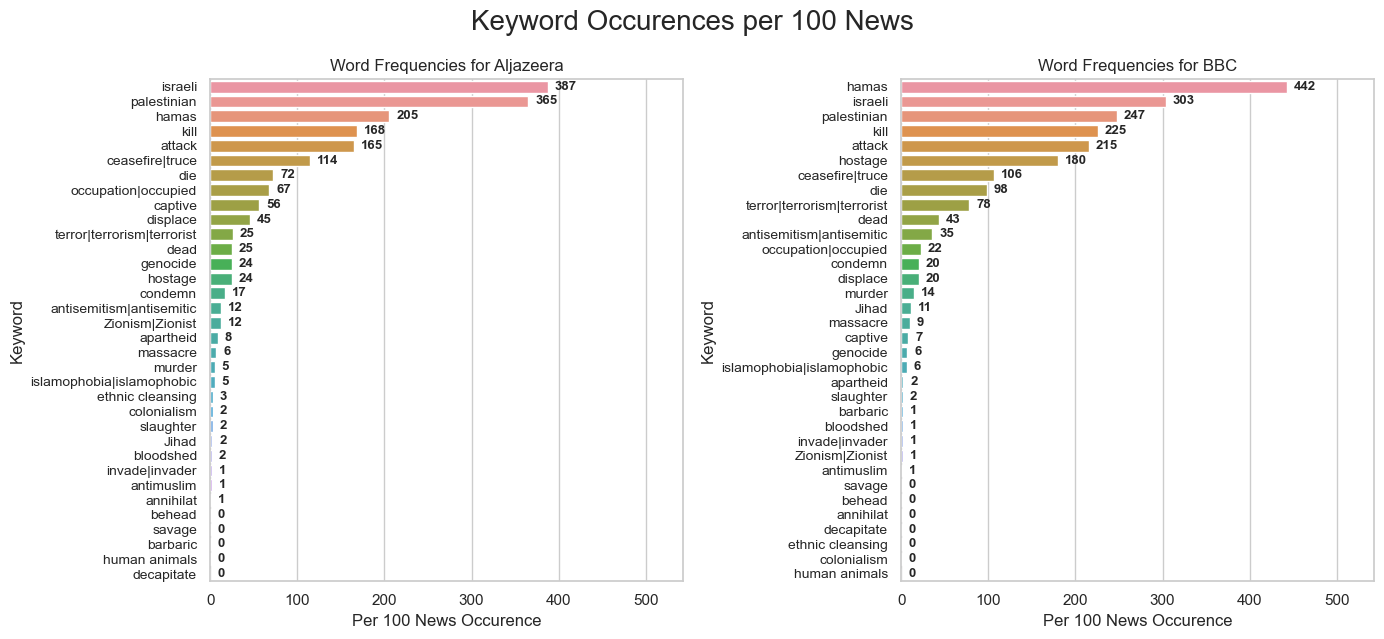

In [213]:
plt.figure(figsize=(14, 6.5))
max_frequency = 0

for i, source in enumerate(df['source'].unique()):

    texts_source = df[df['source'] == source]['text']
    freq_source = calculate_word_frequencies(texts_source, keywords)

    df_source = pd.DataFrame(pd.Series(freq_source), columns=['frequency']).reset_index()
    df_source.columns = ['keyword', 'frequency'] 
    
    sentence_count = texts_source.apply(lambda x: len(x)).sum()

    
    df_source['occurence_per_news'] = df_source['frequency'] / len(texts_source) * 100

    df_source_sorted = df_source.sort_values(by='occurence_per_news', ascending=False)
    
    # Plotting the barplot for the current source with words in descending frequency
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(data=df_source_sorted, x='occurence_per_news', y='keyword')
    #sns.barplot(data=df_source_sorted, x='frequency', y='keyword')
    plt.title(f'Word Frequencies for {source}')
    plt.xlabel('Per 100 News Occurence')
    plt.ylabel('Keyword')
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    xytext=(5, 0), 
                    textcoords='offset points', 
                    ha='left', 
                    va='center', 
                    fontsize=9.5,
                    fontweight='bold')
        
    ax.tick_params(axis='y', labelsize=10)

    max_frequency = max(max_frequency, df_source['occurence_per_news'].max())

# Set the same x-axis limits for both subplots
for i in range(1, 3):
    plt.subplot(1, 2, i)
    plt.xlim(0, max_frequency + 100) 

plt.suptitle('Keyword Occurences per 100 News', fontsize=20)
plt.tight_layout()
plt.show()

Now that we adjusted for the number of news, we are allowed for a more accurate cross-comparison between two sources.
- The word "Hamas" is used twice as more frequently in BBC compared to Al-jazeera. 
- The word "Palestinian" gets only half as coverage as "Hamas" in BBC news. The situation is reversed in the Al-jazeera with Palestinians achieving twice  as more coverage as Hamas.
- Aljazeera has used the term genocide 4 times more frequently than BBC.
- Aljazeera had a balanced use of the terms "Zionism" and "antisemitism", on the other hand, BBC deployed the term "antisemitism" 3 times more often than Al-jazeera, while almost fully refraining from the use of the word "Zionism".

# Media Coverage of Fatalities
In our analysis of media bias and framing, a topic of particular interest is how much coverage fatalities from each party has received in different news sources. Of course, there might be different interpretations on a balanced / unbiased coverage.

Is there an equal coverage of Palestinian and Israeli casualties? Does an equal coverage imply an unbiased approach? Or should we expect the coverage to be proportionate to the number of fatalities / daily occurrence of fatalities?

These are questions open to debate.
However, our attempt in this section, is at least to detect, quantify and visualize the differences in the reference to war casualties of each party in BBC and Al-jazeera news online.

Here, we will deploy two different NLP techniques for a sentence-level analysis among the sentences reporting fatalities:
- 1. Identification of the party suffering the casualties using the dependency parsing of SpaCy.
- 2. Identification of the party suffering the casualties by fine-tuning a pre-trained LLM (BERT).

## 1- SpaCy Dependency Tags Method

In this approach, we use the noun chunks, which is one of the dependency parsers of SpaCy to get:
- if the sentence is in active or passive voice
- what is the subject of the sentence
among the sentences which contain the words "killed", "murdered" and "slaughtered"

Then by looking at the verb's voice and the corresponding subject, we can deduce which party's fatalities are reported in that given sentence.

Strategy:
- For each noun chunk in the sentence, we looked for the chunk whose chunk.root.head.text value is one of our three keywords: "killed", "murdered" or "slaughtered"
- With chunk.root.dep_ method, we obtained the passive/active voice use of that particular verb. This method normally return nsubj for active sentences and nsubjpass for passive sentences
- chunk.text argument in these instances would print out the subject that performs the action. So we searched for the words Israel, Palestine, Israeli, Palestinians and Hamas within these chunk.texts


Let's download the SpaCy's english language model:

In [48]:
nlp = spacy.load("en_core_web_sm")

Now, we build a subset of the data from the sentences which have used the three keywords:

In [52]:
keywords = ['killed', 'murdered', 'slaughtered']
df['mention_killed'] = df['body'].apply(lambda x: [text for text in x if any(word in text.lower() for word in keywords)])

counter_killed = 0
for row in df['mention_killed']:
    counter_killed += len(row)
print("We found", counter_killed, "sentences that contains at least one of the keywords killed, murdered or slaughtered")

We found 2482 sentences that contains at least one of the keywords killed, murdered or slaughtered


In [47]:
df_killed = df[df['mention_killed'].apply(len) > 0].reset_index(drop=True)
df_killed.head()

,title,body,date,source,link,text,mention_killed,token_tag_pairs
0,"US army attacks three Houthi boats in Red Sea,...",[Yemen’s Houthi rebels say they have lost at l...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/us-f...,Yemen’s Houthi rebels say they have lost at le...,[He said the latest clash marked serious escal...,"[[(He, nsubj), (said, ROOT), (the, det), (late..."
1,Pro-Palestine campaigners call for Gaza ceasef...,[Activists have launched global campaign askin...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/pro-...,Activists have launched global campaign asking...,"[With nearly 30,000 civilians killed, includin...","[[(With, prep), (nearly, advmod), (30,000, num..."
2,Walkout over weapons: British school students ...,"[ At exactly 11am on Saturday in mid-November,...",2023-12-31,Aljazeera,https://www.aljazeera.com/features/2023/12/31/...,"At exactly 11am on Saturday in mid-November, ...",[Student organisers of the rally read out spee...,"[[(Student, compound), (organisers, nsubj), (o..."
3,What’s the Philadelphi Corridor border zone th...,[Israel has said it wants to take control of t...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/what...,Israel has said it wants to take control of th...,[Israel’s war on the besieged enclave has kill...,"[[(Israel, poss), (’s, case), (war, nsubj), (o..."
4,Netanyahu says Gaza-Egypt border zone should b...,[The border zone between the Gaza Strip and Eg...,2023-12-31,Aljazeera,https://www.aljazeera.com/news/2023/12/31/neta...,The border zone between the Gaza Strip and Egy...,[Israel’s relentless bombing and ground offens...,"[[(Israel, poss), (’s, case), (relentless, amo..."


In [49]:
voice = {}
voice['source']=[]
voice['voice']=[]
voice['chunk']=[]
voice['party_who_dies'] = []
for i, source in enumerate(df['source'].unique()):
    
    
    texts= df_killed[df_killed['source'] == source]['mention_killed']

    for text in texts:
        for sentence in text:
            doc = nlp(sentence)
            for chunk in doc.noun_chunks:
                if chunk.root.head.text in keywords:
                    if chunk.root.dep_ == "nsubj":
                        voice['voice'].append('active')
                        voice['source'].append(source)
                        voice['chunk'].append(chunk.text)
                        if "Palestin" in chunk.text or "Hamas" in chunk.text:
                            voice['party_who_dies'].append("Israelis")
                        elif "Israel" in chunk.text:
                            voice['party_who_dies'].append("Palestinians")
                        else:
                            voice['party_who_dies'].append(None)
                    elif chunk.root.dep_ == "nsubjpass":
                        voice['voice'].append('passive')
                        voice['source'].append(source)
                        voice['chunk'].append(chunk.text)
                        if "Palestin" in chunk.text or "Hamas" in chunk.text :
                            voice['party_who_dies'].append("Palestinians")
                        elif "Israel" in chunk.text:
                            voice['party_who_dies'].append("Israelis")
                        else:
                            voice['party_who_dies'].append(None)


Let's find out how voice_df dataframe looks like

In [50]:
voice_df = pd.DataFrame(voice)
voice_df.head()


,source,voice,chunk,party_who_dies
0,Aljazeera,passive,"at least 21,822 Palestinians",Palestinians
1,Aljazeera,active,that,None
2,Aljazeera,active,"nearly 30,000 civilians",None
3,Aljazeera,active,Israel’s brutal military offensive,Palestinians
4,Aljazeera,active,Israeli bombs,Palestinians


In [52]:
print("With this technique, we analyzed", len(voice_df), "sentences from", len(df_killed), "news.")
print("However, this approach managed to idenfity the party that suffered the reported fatalities only in",
     len(voice_df[voice_df['party_who_dies'].notna()]), "of the sentences.")

With this technique, we analyzed 2065 sentences from 970 news.
However, this approach managed to idenfity the party that suffered the reported fatalities only in 500 of the sentences.


#### Comments:

The reason for this low capacity of identification is due to the fact that SpaCy's noun chunks can only make us correctly identify the party suffering the fatality when the verb and subject that performs the verb are related to each other by a direct clause. 

However, in a sentence like 'The war began when Hamas carried out shock cross-border attack on Israeli territory on October 7 that killed about 1,140 people, mostly civilians, according to Israel.', in which the subject and the verb "killed" are connected by a relative clause (...Hamas carried out...attack...that killed), this methods fall too simplistic to detect Hamas as the subject, and instead only returns "that" as the child word with nsubj tag attached to the verb killed as a "head" word.

Still let's visualize the results for this 500 sentences:

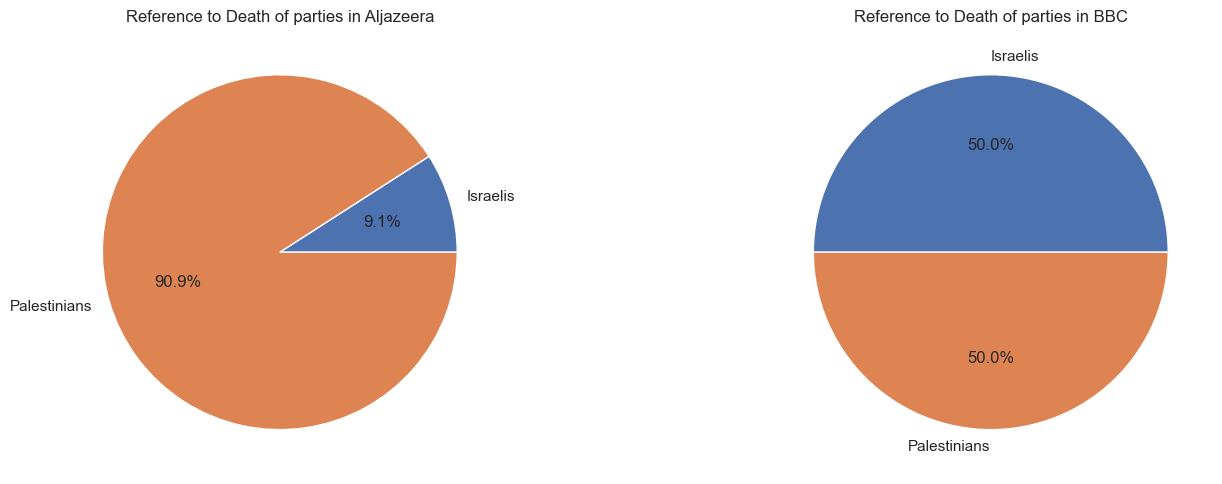

In [53]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

for i, source in enumerate(voice_df['source'].unique()):
    data = voice_df[voice_df['party_who_dies'].notna()]
    data = data[data['source']==source]
    data = data.groupby(['party_who_dies'])['party_who_dies'].count().reset_index(name='count')

    # Plot pie chart for each source
    ax = axs[i]
    ax.pie(data['count'], labels=data['party_who_dies'], autopct='%1.1f%%')
    ax.set_title(f'Reference to Death of parties in {source}')

plt.tight_layout()
plt.show()

In 500 sentences we managed to idenfity casualties with SpaCy's dependency parser:
- Aljazeera refers to the Israeli fatalities 9.1% of the times
- whereas BBC reports both sides of fatalities on an equal scale.

To the extent these reportings are proportionate to daily occurrence of attacks and casualties is open to discussion, yet, there seems to be a clear distinction between two sources.

However, low number of sentences identified is not the only limit and potential bias of this approach. 
When using this strategy, we also failed to take into account other conjugations of these verbs such as ("kill, kills, killing, murdering, murders, etc) as this is a very simple string based technique.

Instead, the second method we will try will allow for a much higher flexibility in conjugations, and will rely on word embeddings, allowing for semantic understanding.

## 2- Transfer Learning and Fine-tuning LLM method
Known as one of the State-of-the-art (Large Language Models) LLMs, BERT (Bidirectional Encoder Representations from Transformers) revolutionized the NLP by comprehensively understanding context in language through bidirectional training, enabling deeper semantic comprehension.

Developed through extensive pre-training on large-scale corpora, BERT's bidirectional approach captures context from both directions, and it can capture relationships between words, encode contextual nuances and improve performance across various NLP tasks.

Here, we designated a text classification task on a AI-generated artificial data to train a BERT-based model.

- First, using several prompts, we asked ChatGPT to generate over 300 sentences referring to the death of Palestinians, fatalities from Israeli attacks, deaths in Gaza. This constituted our training data for sentences mentioning Palestinian fatalities.
- Unfortunately, after first few instances of succesful retrieval, ChatGPT rejected to generate further data due to the sensitivity of the topic, yet, we augmented our data by replacing the words in the previous sentences with "Israelis", "Hamas attacks", "deaths in Israel" in the appropriate manner to generate also sufficient train data for Israeli fatalities.
- Finally, we generated some na sentences in which the name of the party suffering fatalities is not available.

### Model Training and Validation performance
Then, using this artifical dataset with three labels (Israeli fatalities, Palestinian fatalities, Not available), we fine-tuned classic BERT model for our particular task of sentence classification. After a few epochs, the model achieved 0.95 accuracy and 0.95 F1 scores on the validation set.

For more information on AI-generated sentences, model training and model performance on the train and validation set, you can check out BERT_model.ipynb


### Applying the model on the real non-labeled Dataset
- One advantage of this model is that we are finally allowed to check other common synonyms of death in news coverages. 
- Our prediction dataset will be composed of real-news sentences that have the following keywords: kill, murder, slaughter, massacre, casualties, fatality, fatalities, die and death
- we save the relevant subset into df_death.json file, and then predicted labels for each sentence in this dataset using our model in a Colab environment, which has allowed us to accelerate the computation by Colab's GPU.


In [54]:
keywords = ['kill', 'murder', 'slaughter', "massacre", "casualties", "fatalit", "die", "dead"]
df['mention_death'] = df['body'].apply(lambda x: [text for text in x if any(word in text.lower() for word in keywords)])

df_death = df[df['mention_death'].apply(len) > 0].reset_index(drop=True)
df_death.to_json("df_death.json")

As you can verify in BERT_model.ipynb file, we saved the model's predictions in the df_death_pred.json file.

Let's import that file for analysis.

In [53]:
with open('df_death_pred.json', 'r') as file:
    data = json.load(file)
df_pred = pd.DataFrame(data)
df_pred.head()

,source,sentence,party_who_dies_pred
0,Aljazeera,"The US helicopters sunk three of the boats, ki...",Not available
1,Aljazeera,He said the latest clash marked serious escala...,Not available
2,Aljazeera,The unrest in the Red Sea comes as anger grows...,Palestinians
3,Aljazeera,The war began when Hamas carried out shock cro...,Israelis
4,Aljazeera,An estimated 70 percent of respondents said th...,Israelis


In [64]:
print("Prediction dataset contains", len(df_pred),
      "sentences assigned with the labels 'Israelis', 'Palestinians' and 'Not available'.")

Prediction dataset has 5477 sentences assigned with the labels 'Israelis', 'Palestinians' and 'Not available'.


#### Check the model's predictions
Let's print out 50 random sentences from the dataset to see how they are classified by the model:

In [56]:
random_indices = random.sample(range(len(df_pred)), 50)

for i in random_indices:
    print(df_pred['sentence'][i])
    print(df_pred['party_who_dies_pred'][i])
    print( )

“If American soldiers and personnel were killed, the United States would likely respond in very serious manner, and we would witness significant escalation.
Not available

Al Jazeera has said it will refer Abudaqa’s killing to the International Criminal Court (ICC), stating that the strike took place within context of “recurrent attacks on the Network’s crews working and operating in the occupied Palestinian territories and instances of incitement against them”.
Palestinians

So many of them are dead now that Ahmed stumbles as he remembers the names and ages of each one.
Not available

Al-Hassan Mattar, 21-year-old studying English literature, was killed, along with his father, 12-year-old sister Tala, grandmother and several relatives who were seeking shelter with them.
Not available

But he told the BBC that civilian casualties in Gaza were too high.
Palestinians

He fears public health crisis because so many of the dead are under the rubble.
Not available

At least 20,424 Palestinia

Notice the model's predictions are accurate most of the time even on these dataset which contains sentences with more complex structure and syntax than those on which the model is trained.

- On the other hand, a more ideal approach could have been manually annotating a subsample of the sentences so as to familiarize the algorithm with harder structures and adding these sentences also to the train data.
- A second improvement to make could be to change the unit of analysis from sentences to paragraphs since we know the Transformer models are impressively competent in grasping context and understanding dependencies thanks to the attention mechanism they use. In our approach, our document (unit of analysis) was sentence, hence sometimes the model failed to identify the party who dies if it was mentioned in the previous sentence or within the same paragraph.
- Take this example:
"They killed at least 1,400 people, most of them civilians, and took another 222 people as hostages.
Not available"

This is from the results we just printed above. As human readers with the contextual information on the topic, having read the sentence, we can easily understand that it is speaking about the Israeli casualties withput even needing to the check the previous sentence. However, for the algorithm the only way to understand who "They" is, is to have access to the paragraph-level information.

### Visualize the Media Coverage of Casualties

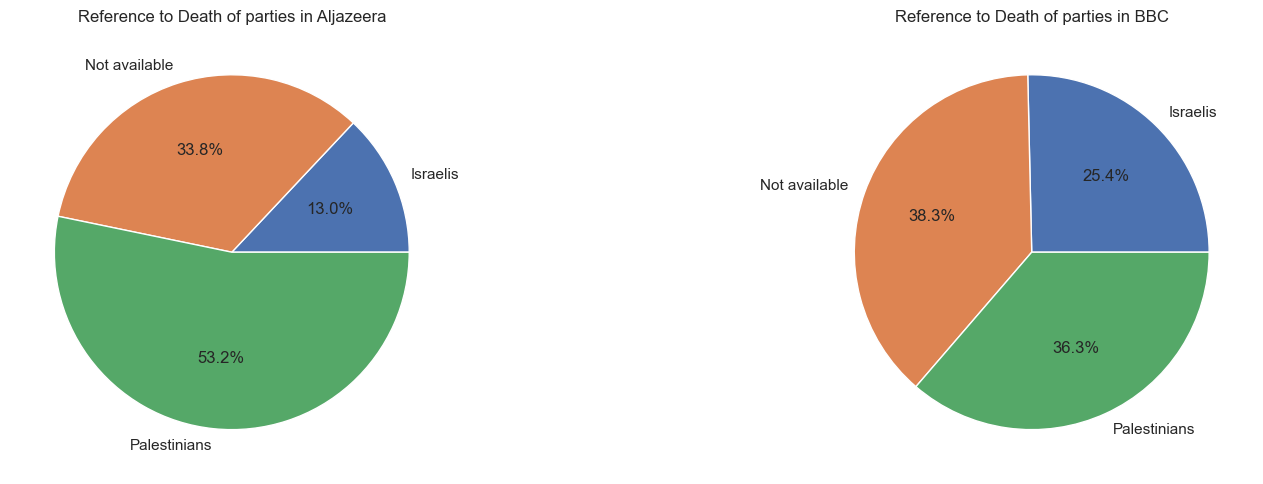

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

for i, source in enumerate(voice_df['source'].unique()):
    data = df_pred[df_pred['party_who_dies_pred'].notna()]
    data = data[data['source']==source]
    data = data.groupby(['party_who_dies_pred'])['party_who_dies_pred'].count().reset_index(name='count')

    # Plot pie chart for each source
    ax = axs[i]
    ax.pie(data['count'], labels=data['party_who_dies_pred'], autopct='%1.1f%%')
    ax.set_title(f'Reference to Death of parties in {source}')

plt.tight_layout()
plt.show()

Analyzing over 5000 sentences, this approach has definitely returned more accurate insight on the news coverages:
- Both sources seem to grant a higher coverage to Palestinian casualties, which might be thought as more proportionate to the number, frequencies and timings of these fatalities.
- On the other hand, we still observe a significant difference between two sources in their coverage of Israeli casualties, which find much less coverage in Al-Jazeera.

## Direct vs Indirect reporting

Media framing does not only operate through the number of references / coverages though. It is also highly linked to how a news is serviced / reported.

When skimming the articles on the topic, we identify two distinct way of reporting fatalities: direct reporting and indirect reporting.

Here, what we try to detect is different from direct vs indirect speech, which is about if a third agent is quoted directly or indirectly. What we named direct reporting is the instance of reference to the fatalities without mentioning any source for that information. On the other hand, we considered indirect reporting as the instances where the news website explicitly states where the given information is coming from.

To illustrate in two examples from our dataset:
- Direct reporting : Last Monday - two days after Hamas's unprecedented cross border attack that killed 1,400 in Israel - Bisan like thousands of others received text message from the Israeli military.
- Indirect reporting : Two hospitals in central and southern Gaza received 133 bodies of Palestinians killed in Israeli bombings over the past 24 hours, health ministry officials in Gaza said on Saturday.

We check if a given sentence that reports the death tolls mentions any source or not by searching for the keywords like "said", "says", "reported","report","announce", "announced","according to"...

Normally, indirect reporting could be considered a strategy to improve the credibility and reliability of the information shared. If deployed for such purposes, we should not expect to find a significant difference between the use of direct and indirect reporting depending on the party suffering from the fatalities.

Yet, having noticed a number of patterns, we decided to test this in a quantitative manner:

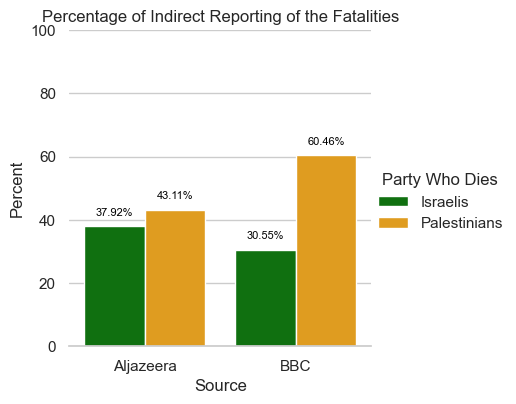

In [73]:
source_counts = {'source': [], 'party_who_dies': [], 'count': []}

for source in df['source'].unique():
    for party in ["Israelis", "Palestinians"]:
        count = 0
        data = df_pred[(df_pred['source'] == source) & (df_pred['party_who_dies_pred'] == party)]
        for j in range(len(data)):
            occurrences = re.findall(r'said|says|reported|report|announce|according to', 
                                     data['sentence'].iloc[j], flags=re.IGNORECASE)
            count += len(occurrences)
        source_counts['source'].append(source)
        source_counts['party_who_dies'].append(party)
        source_counts['count'].append(count / len(data) * 100)

source_counts_df = pd.DataFrame(source_counts)

sns.set(style="whitegrid")
g = sns.catplot(
    data=source_counts_df, kind="bar",
    x="source", y="count", hue="party_who_suffer_fatalities",
    palette={"Israelis": "green", "Palestinians": "orange"}, height=4, aspect=1
)
g.despine(left=True)
g.set_axis_labels("Source", "Percent")
g.legend.set_title("Party Who Dies")
plt.title('Percentage of Indirect Reporting of the Fatalities')
plt.ylim(0, 100)

# Add values (counts) at the top of each bar
for p in g.ax.patches:
    g.ax.annotate(f'{p.get_height():.2f}%', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', xytext=(0, 10), 
                  textcoords='offset points', fontsize=8, color='black')

plt.show()

We encountered some interesting findings here:
- Al-jazeera seems to use indirect reporting 37.9% of the times for Israeli casualties and 43.1% of the times for Palestinian casualties. The media channel seems to use direct reporting for death tolls in general for the majority of the time.
- On the other hand, when we look at the BBC news,  we find a very dramatic discrepancy in preferences: Apparently, the channel adopts indirect reporting technique for Palestinian losses twice as more frequenctly than for Israeli losses.
- Since there is a big difference in the reporting style, BBC's uses of direct vs indirect speech seems less like a reliable reporting strategy than a deliberate media framing.

We have decided to explore this further. 
For this purpose, we printed out some of the BBC's sentences that refers to the Palestinian fatalities.

In [63]:
BBC_Pal = df_pred[(df_pred['source']=="BBC") & (df_pred['party_who_dies_pred']=="Palestinians")]

random_indices = random.sample(range(len(BBC_Pal)), 10)
for i in random_indices:
    print(BBC_Pal['sentence'][i])
    print()


The Hamas-run health ministry in Gaza said more than 10,000 people had been killed in the territory since 7 October.

Those attending the rally had been urged to write their names on their arms as gesture of solidarity with the besieged population of Gaza, who have used the method so they can be identified and buried with relatives if they are killed.

According to the Hamas-run health ministry, the death toll in Gaza since then has reached 13,300.

The UN has expressed grave concern after Israeli strikes reportedly killed dozens of people in Bureij, Nuseirat and Maghazi camps in recent days.

BBC Verify has verified graphic videos showing badly injured and possibly dead people lying outside the Al-Shifa hospital.

Since then, more than 19,400 people have been killed in Gaza, about 70% of them women and children, according to the Hamas-run health ministry.

Since then, Gaza's Hamas-run health ministry says more than 14,500 people have been killed in Israel's retaliatory campaign

Her d

Even in this randomly printed subset of 10 sentences, we found the channel to have used 6 times the expression of "Hamas-run health ministry" for citing the source for the information on fatalities.

We printed out a few random sentences also for Israeli fatalities:

In [70]:
BBC_Isr = df_pred[(df_pred['source']=="BBC") & (df_pred['party_who_dies_pred']=="Israelis")]

random_indices = random.sample(range(len(BBC_Isr)), 10)
for i in random_indices:
    print(BBC_Isr['sentence'][i])
    print()


Its Prime Minister Benjamin Netanyahu swore "mighty vengeance" after Hamas breached the border and killed around 1,200 people, mostly Israeli civilians, on 7 October.

It accuses Hamas of stockpiling hundreds of thousands of litres of diesel and refusing to share it.

It accused Zubeidi of involvement in two shootings in May in which an Israeli civilian was killed and several soldiers were wounded.

The Hamas attack on Israel on 7 October killed 1,400 people, mostly civilians, while more than 200 people were taken hostage.

Mr Millar, Clwyd West MS, said the 7 October attacks by Hamas, which killed 1,400 people, were the worst atrocity committed against the Jewish people since the holocaust.

The first shows four Israeli soldiers dancing with guns, set against blue sky.

He added that mediators hoped to receive information from Hamas about the more than 150 Israelis and foreign nationals still being held hostage, who include children as young as 10 months old as well as number of soldi

When we check the sentences classified as reporting Israeli casualties by our model, the channel seems to very rarely cite any source for that information, let alone repeats any phrase to remind that information is -naturally-coming from one of the two parties of the conflict in a manner to discredit its reliability and tend to take this numbers just granted. This is a pattern we found quite interesting.

In [71]:

count_indirect = 0
for sentence in BBC_Pal['sentence']:
    occurrences = re.findall(r'hamas-run health ministry',
                             sentence, flags=re.IGNORECASE)
    count_indirect += len(occurrences)

print(f"BBC cited 'Hamas-run health ministry' as the source for information on Palestinian casualties {count_indirect} times in", 
      len(BBC_Pal), "sentences.")



BBC cited 'Hamas-run health ministry' as the source for information on Palestinian casualties 235 times in 994 sentences.


We have already found out that BBC has the tendency to deploy indirect reporting 60.4% of the time they report Palestinian deaths. This means that among 994 sentences that reported Palestinian deaths, BBC chose to use indirect reporting approximately 596 times. And for 235 of these 956 times, they cite the source as "Hamas-run health ministry".

Another but less striking pattern we detected is that BBC's tendency to use the word "unprecedented" when refering to Hamas attack. Though it is a word that could be interpreted in many ways, we find this word choice interesting and bold especially for about a fatal conflict that traces back to more than 50 years ago. 

## Bonus: Same News' Coverage on Different Media

Finally, despite the advances in the usage of NLP in social sciences in general, and in the detection of media bias and framing in particular, these phenomena are still best detected and identified by human readers. Therefore, as a bonus, we designed a special function that prints out random news from the selected media channel of your choice (BBC or Al-Jazeera) and then searches and returns the coverage of the same news in the other media channel whenever available.

This function uses:
- SpaCy's en_core_web_md model which, differently from en_core_web_sm model, represents words in vectors for tokenization
- Word2Vec model from gensim library which allows for training of the model on a specific vocabulary and a selected vocabulary size for vectorization
- cosine_similarity function to calculate similarity between documents (in this case news articles) in terms of the cosine distances between their mean vectors (we chose to represent each article by the average of the vectors (embeddings) representing each word inside.

In [83]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity

In [84]:
nlp = spacy.load('en_core_web_md')

In [85]:
def find_the_same_news_in_other():
    news_source = str(input("The news source from which you want to print a random news: "))
    df_source = df[df['source'] == news_source]
    idx = df_source.sample(random_state=np.random.RandomState(), n=1).index[0]
    date = df['date'][idx]

    print("Title of the news you chose: \n", df['title'][idx])
    print("Content of the news you chose: \n", df['text'][idx])

    # Initialize Word2Vec model and build vocabulary
    sentences = [text.split() for text in df['text']]
    word2vec_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
    
    # Infer Word2Vec vectors for the selected document
    tokens = nlp(df['text'][idx])
    query = np.mean([word2vec_model.wv.get_vector(token.text) for token in tokens if token.text in word2vec_model.wv], axis=0)

    # Generate cosine similarity scores with other documents
    scores = []
    for i in range(len(df)):
        if df['source'][i] != news_source and df['date'][i] == date:
            tokens = nlp(df['text'][i])
            other_doc_vec = np.mean([word2vec_model.wv.get_vector(token.text) for token in tokens if token.text in word2vec_model.wv], axis=0)
            if other_doc_vec is not None and not np.isnan(other_doc_vec).any() and query is not None and not np.isnan(query).any():
                score = cosine_similarity([query], [other_doc_vec])[0][0]  # Compute cosine similarity directly
                scores.append((i, score))

    scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, _ in scores]
    other_source = df[df['source'] != news_source]['source'].unique()
    print(f"\nSimilar News from {other_source[0]} \n")

    if top_indices:
        top_idx = top_indices[0]
        print("Title:", df['title'][top_idx])
        print("News:", df['text'][top_idx], "\n")
    else:
        print(f"No similar news in {other_source[0]}.")

In [92]:
find_the_same_news_in_other()

The news source from which you want to print a random news: BBC
Title of the news you chose: 
 Why has the Gaza ceasefire come to an end?
Content of the news you chose: 
 Fighting resumed between Israel and Hamas on Friday morning, ending seven-day ceasefire between the two sides that had seen hostages and prisoners released and much-needed humanitarian assistance reaching the Gaza Strip Here's look at some of the key questions around the latest developments. An hour before the ceasefire was due to end at 07:00 local time (05:00 GMT), the Israel Defense Forces (IDF) reported that sirens were sounding for communities close to the Gaza Strip - it then said it had intercepted rocket fired from the enclave. An hour later, Israel's military said fighting had resumed, accusing Hamas of violating the terms of the agreement. The IDF then said its fighter jets were striking Hamas targets in the Gaza Strip. Shortly after, Israel's Prime Minister Benjamin Netanyahu said Hamas had not "met its obl

In [93]:
find_the_same_news_in_other()

The news source from which you want to print a random news: Aljazeera
Title of the news you chose: 
 COP28: Israel should not be allowed to greenwash its war on Gaza
Content of the news you chose: 
 As its war on Gaza continues with no end in sight, Israel will be participating in the 28th United Nations Climate Change Conference (COP28) which started on Thursday in Dubai. For the Israeli government, this will be an invaluable opportunity to engage in “green diplomacy”, promote its climate technologies, and divert the international community’s attention from its illegal occupation, apartheid and ongoing war crimes against the Palestinians. Indeed, participating in the world’s top climate event while continuing to indiscriminately bomb an unlawfully besieged territory will allow Israel, which has long been trying to conceal its theft of Palestinian land and resources under cloak of pseudo “environmentalism”, to push its extensive “greenwashing” agenda to dangerous new extremes. Given th

In [231]:
# Example usage
find_the_same_news_in_other()

The news source from which you want to print a random news: Aljazeera
Title of the news you chose: 
 UN Security Council passes resolution on increased Gaza aid delivery
Content of the news you chose: 
 The United Nations Security Council has passed resolution to boost humanitarian aid to Gaza, following several delays over the last week as the United States lobbied to weaken the language regarding calls for ceasefire. The resolution, which calls for steps “to create the conditions for sustainable cessation of hostilities”, passed on Friday with 13 votes in favour, none against, and the US and Russia abstaining. The vote came amid international calls to bring the months-long conflict to an end, as Israeli forces pummel Gaza with one of the most destructive campaigns in modern history and humanitarian conditions in the besieged strip reach critical levels . More than 90 percent of Gaza’s 2.3 million residents have been displaced, and conditions under Israeli siege and bombardment have b